In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
#read data
df = pd.read_csv('/content/satesoft_data.csv')

In [ ]:
#cleaning data
df['sold_on'] = pd.to_datetime(df['sold_on'], errors='coerce') #convert dates
df = df[df['client_id'].notna()]      # keep only customers with data

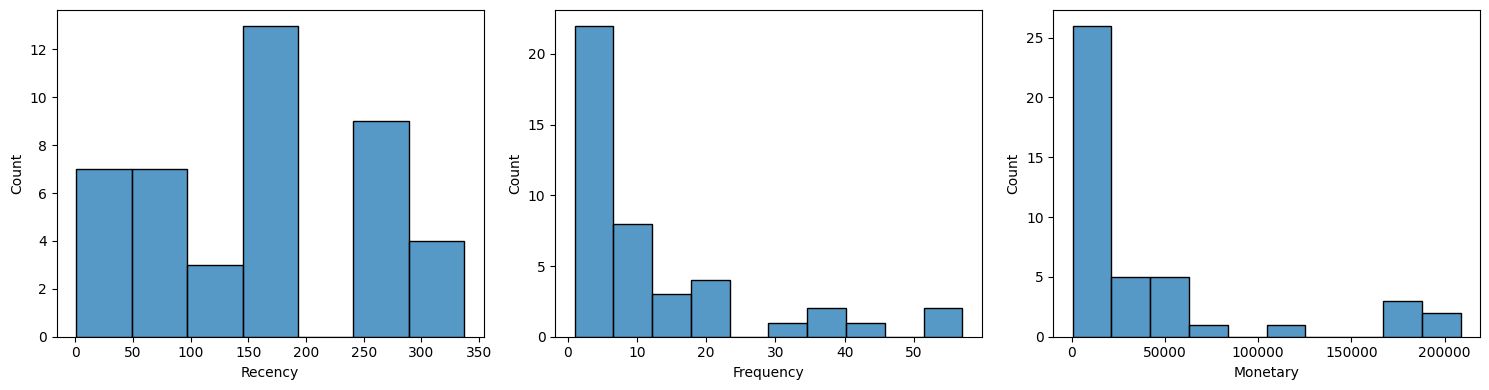

In [ ]:
#RFM Graphs
#Snapshot is 1 day after most recent transaction, ensuring recency is captured
snapshot_date = df['sold_on'].max() + pd.Timedelta(days=1)


rfm = df.groupby('client_id').agg({
    'sold_on': lambda x: (snapshot_date - x.max()).days,  # Recency = days since last purchase
    'id': 'count',                                        # Frequency = number of transactions
    'total_cost': 'sum'                                   # Monetary = total revenue from customer
}).rename(columns={'sold_on':'Recency','id':'Frequency','total_cost':'Monetary'})

#remove invalid numbers
rfm = rfm.replace([np.inf, -np.inf], np.nan)

#drop rows with missing data
rfm = rfm.dropna()
fig,ax = plt.subplots(1,3,figsize=(15,4))
sns.histplot(rfm['Recency'], ax=ax[0])
sns.histplot(rfm['Frequency'], ax=ax[1])
sns.histplot(rfm['Monetary'], ax=ax[2])
plt.tight_layout()

In [ ]:
#Assigning Scores - May Delete
rfm['R_score'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'),5,labels=[1,2,3,4,5])

rfm['RFM_score'] = rfm[['R_score','F_score','M_score']].sum(axis=1).astype(int)

In [ ]:
#Setting Up Clustering
X = rfm[['Recency','Frequency','Monetary']]

scaler = StandardScaler()
scaled = scaler.fit_transform(X)  # scaled is now normalized data

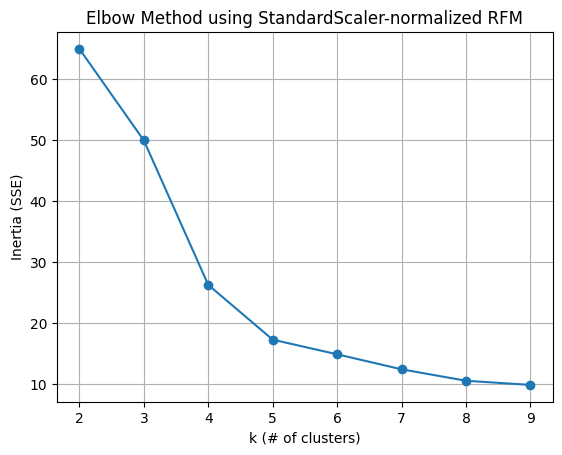

In [ ]:
#K Means Clustering - Elbow at K=5
sse=[]
for k in range(2,10):
    km = KMeans(n_clusters=k,random_state=42)
    km.fit(scaled)
    sse.append(km.inertia_)

#Elbow curve plot
plt.plot(range(2,10),sse,marker='o')
plt.title("Elbow Method using StandardScaler-normalized RFM")
plt.xlabel("k (# of clusters)")
plt.ylabel("Inertia (SSE)")
plt.grid()

In [ ]:
k = 5  # elbow curve result
model = KMeans(n_clusters=k,random_state=42)

#assigning cluster to each customer
rfm['Cluster'] = model.fit_predict(scaled)

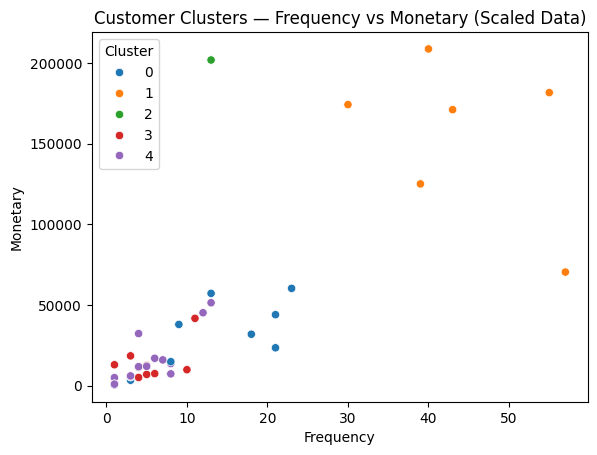

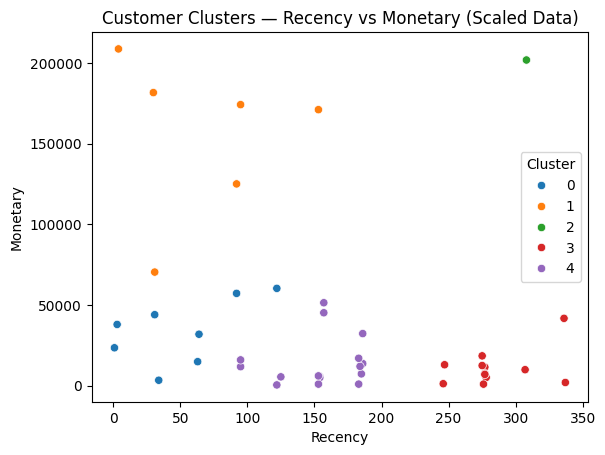

In [ ]:
# 5 Clusters for Different Customer Groups
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Clusters — Frequency vs Monetary (Scaled Data)")
plt.show()

sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='tab10')
plt.title("Customer Clusters — Recency vs Monetary (Scaled Data)")
plt.show()

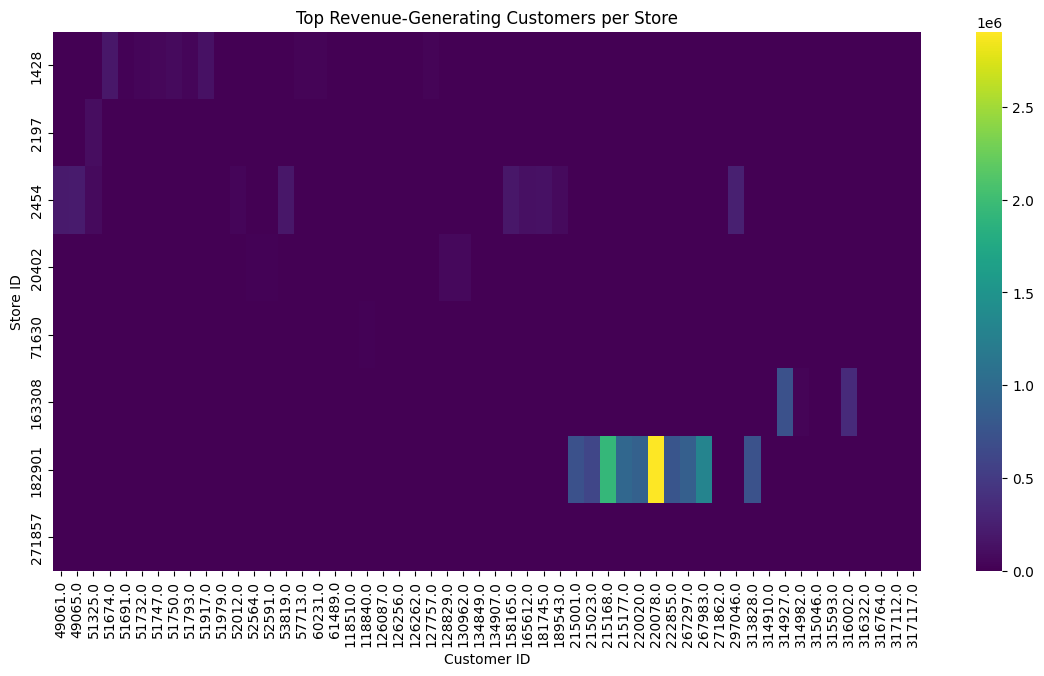

In [ ]:
#Highest Revenue Customers per Store

store_customer_rev = (
    df.groupby(['shop_id','client_id'])['total_cost']
      .sum()
      .reset_index()
)

# Top 10 customers per store by total revenue
top10_store_customers = (
    store_customer_rev.sort_values(['shop_id','total_cost'], ascending=[True,False])
                      .groupby('shop_id')
                      .head(10)
)
pivot = top10_store_customers.pivot_table(
    index='shop_id',
    columns='client_id',
    values='total_cost'
).fillna(0)

plt.figure(figsize=(14,7))
sns.heatmap(pivot, cmap="viridis")
plt.title("Top Revenue-Generating Customers per Store")
plt.xlabel("Customer ID")
plt.ylabel("Store ID")
plt.show()

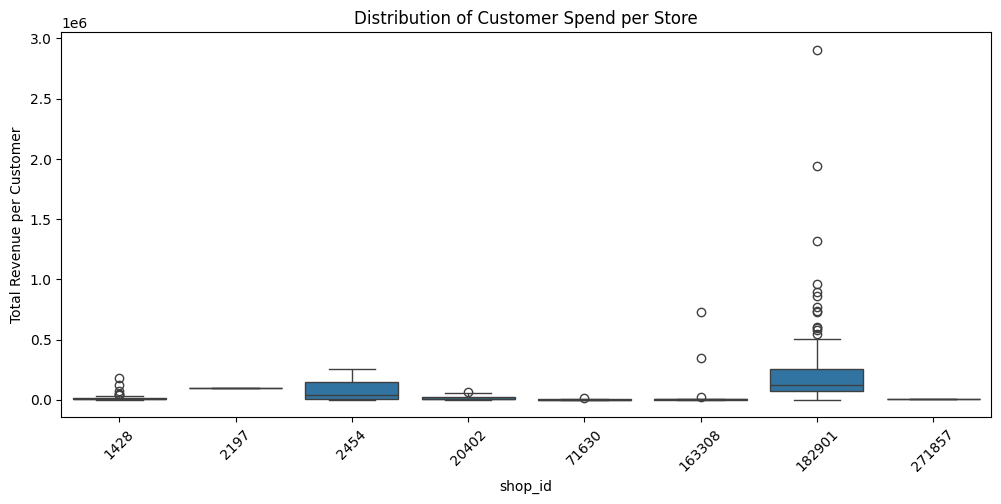

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(data=store_customer_rev, x='shop_id', y='total_cost')
plt.title("Distribution of Customer Spend per Store")
plt.ylabel("Total Revenue per Customer")
plt.xticks(rotation=45)
plt.show()

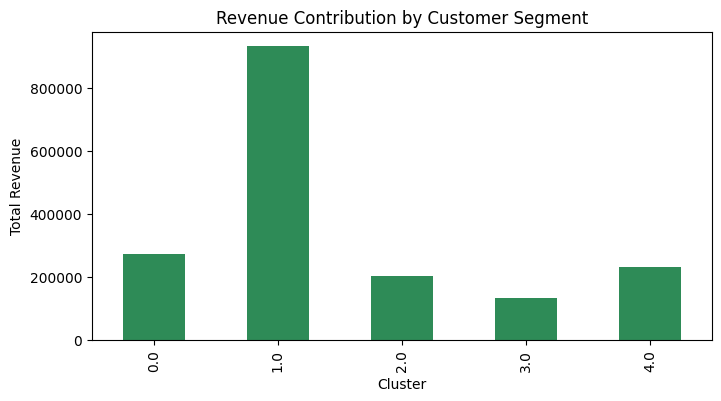

In [ ]:
segment_rev = df.groupby('client_id')['total_cost'].sum().to_frame('Revenue')\
                .join(rfm['Cluster'])\
                .groupby('Cluster')['Revenue'].sum()

segment_rev.plot(kind='bar', figsize=(8,4), color='seagreen')
plt.title("Revenue Contribution by Customer Segment")
plt.ylabel("Total Revenue")
plt.show()

In [ ]:
#Recommendation based on cluster assignment
cluster_recommendations = {
    0: "Offer small spend incentives.",
    1: "Provide VIP perks or bonus rewards.",
    2: "Send a re-engagement discount.",
    3: "Send light reminders only.",
    4: "Encourage more frequent visits."
}

def recommend_for_cluster(cluster_id):
    return cluster_recommendations.get(
        cluster_id,
        "General promotion to increase engagement.")

In [ ]:
if "client_id" not in rfm.columns:
    rfm_display = rfm.reset_index()
else:
    rfm_display = rfm.copy()

# Randomly pick 10 customers
sample_customers = rfm_display.sample(n=10, random_state=2)

# Add a recommendation column
sample_customers["Recommendation"] = sample_customers["Cluster"].apply(recommend_for_cluster)

output = sample_customers[["client_id", "Cluster", "Recommendation"]]
print(output.to_string(index=False))

 client_id  Cluster                      Recommendation
   65875.0        4     Encourage more frequent visits.
   51750.0        1 Provide VIP perks or bonus rewards.
   51928.0        0       Offer small spend incentives.
   49061.0        2      Send a re-engagement discount.
   49837.0        0       Offer small spend incentives.
  118840.0        4     Encourage more frequent visits.
   51917.0        1 Provide VIP perks or bonus rewards.
  128270.0        3          Send light reminders only.
   52564.0        4     Encourage more frequent visits.
  128829.0        0       Offer small spend incentives.
